### Generating human faces with Adversarial Networks (5 points)
<img src="https://www.strangerdimensions.com/wp-content/uploads/2013/11/reception-robot.jpg" width=320>
This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc. 'Cuz when us machines gonna take over Earth, there won't be any more faces left. We want to preserve this data for future iterations. Yikes...

Based on https://github.com/Lasagne/Recipes/pull/94 .

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

from sklearn.datasets import load_digits
#The following line fetches you two datasets: images, usable for autoencoder training and attributes.
#Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset
data,attrs = fetch_lfw_dataset(dimx=36,dimy=36)

#preprocess faces
data = np.float32(data)/255.

IMG_SHAPE = data.shape[1:]

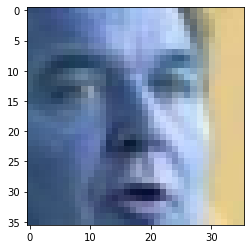

In [2]:
#print random image
plt.imshow(data[np.random.randint(data.shape[0])], cmap="gray", interpolation="none")
plt.show()

# Generative adversarial nets 101

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Deep learning is simple, isn't it? 
* build some network that generates the face (small image)
* make up a __measure__ of __how good that face is__
* optimize with gradient descent :)


The only problem is: how can we engineers tell well-generated faces from bad? And i bet you we won't ask a designer for help. 

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample. 
  * Let's call him __G__(z), where z is a gaussian noise.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake. 
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [3]:
import os
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers as L

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
gpus = tf.config.experimental.list_physical_devices("GPU")
print(gpus)
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
CODE_SIZE = 256

generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE],name='noise'))
generator.add(L.Dense(10*8*8, activation='elu'))

generator.add(L.Reshape((8,8,10)))
generator.add(L.Conv2DTranspose(64,kernel_size=(5,5),activation='elu'))
generator.add(L.Conv2DTranspose(64,kernel_size=(5,5),activation='elu'))
generator.add(L.UpSampling2D(size=(2,2)))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))

generator.add(L.Conv2D(3,kernel_size=3,activation=None))
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               164480    
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 10)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 12, 12, 64)        16064     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 64)        102464    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 34, 34, 32)        18464     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 36, 36, 32)        9

In [5]:
assert generator.output_shape[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE,generator.output_shape[1:])

### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [6]:
discriminator = Sequential()

conv = lambda filters: L.Conv2D(
    kernel_size=3, filters=filters,
    padding='same', activation='relu'
)
discriminator.add(L.InputLayer(IMG_SHAPE)) # 36 * 36 * 3
discriminator.add(conv(16)) # 36 * 36 * 16
discriminator.add(conv(32)) # 36 * 36 * 32
discriminator.add(L.MaxPool2D()) # 18 * 18 * 32
discriminator.add(conv(64)) # 18 * 18 * 64
discriminator.add(conv(128)) # 18 * 18 * 128
discriminator.add(L.MaxPool2D()) # 9 * 9 * 128
discriminator.add(conv(256)) # 9 * 9 * 256
discriminator.add(conv(512)) # 9 * 9 * 512
discriminator.add(L.MaxPool2D(pool_size=3)) # 3 * 3 * 512
discriminator.add(L.GlobalAveragePooling2D()) # 1 * 1 * 512
discriminator.add(L.Flatten()) # 512
discriminator.add(L.Dense(256, activation='tanh'))
discriminator.add(L.Dense(2, activation=tf.nn.log_softmax))
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 36, 36, 16)        448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 9, 256)        

In [7]:
discriminator.load_weights('./discriminator.hdf5')
generator.load_weights('./generator.hdf5')

# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real
* Since discriminator is a differentiable neural network, we train both with gradient descent.

![img](gan.png)

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* Regularize discriminator output weights to prevent explosion
* Train generator with __adam__ to speed up training. Discriminator trains with SGD to avoid problems with momentum.
* More: https://github.com/soumith/ganhacks

### Auxilary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [8]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        plt.xticks(())
        plt.yticks(())
        plt.axis('off')
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5, range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5, range=[0,1])
    plt.legend(loc='best')
    plt.show()

### Training
Main loop.
We just train generator and discriminator in a loop and draw results once every N iterations.

In [9]:
disc_optimizer = tf.optimizers.SGD(1e-3)
gen_optimizer = tf.optimizers.Adam(1e-4)

In [15]:
from IPython import display
from tqdm import tnrange
from time import time
from datetime import timedelta
start = time()

for epoch in tnrange(500000):
    real_data = sample_data_batch(100)
    noise = sample_noise_batch(100)
    
    ########################
    #discriminator training#
    ########################
    # I've train discriminator 5 times more for around  10000 epochs
    # 3 times more for around 10000 epochs
    # 2 times more for around 18000 epochs
    # and equal times for about 40000 epochs
    # decreasing this number I was able to train the generator more
    # for i in range(2):
    with tf.GradientTape() as tape:
        logp_real = discriminator(real_data)
        generated_data = generator(noise)
        logp_gen = -tf.math.log(1-discriminator(generated_data))

        # maximizing the probability of being fake
        d_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])
        #regularize
        d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)
    
    #optimize
    disc_optimizer.minimize(
        d_loss, 
        var_list=discriminator.trainable_weights, 
        tape=tape
    )
    
    with tf.GradientTape() as tape:
        ########################
        ###generator training###
        ########################    
        # maxsimizing the probability of being real
        g_loss = tf.reduce_mean(
            tf.math.log(
                1 - discriminator(generator(noise))
            )[:, 1]
        )

    # optimize
    gen_optimizer.minimize(
        g_loss,
        var_list=generator.trainable_variables,
        tape=tape
    )

    if epoch % 50 == 0:
        display.clear_output(wait=True)
        print(epoch)
        print(timedelta(seconds=time() - start))
        if epoch % 100 == 0:
            discriminator.save_weights('./discriminator.hdf5')
            generator.save_weights('./generator.hdf5')
        sample_images(2,3,True)
        sample_probas(1000)

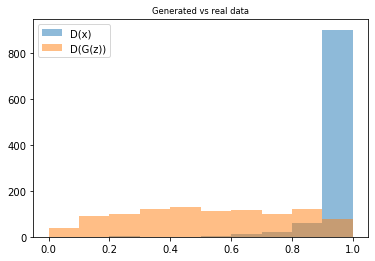

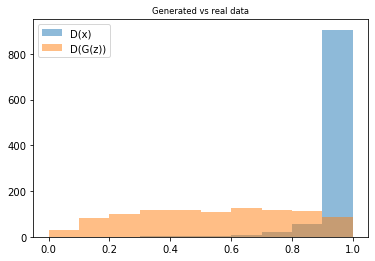

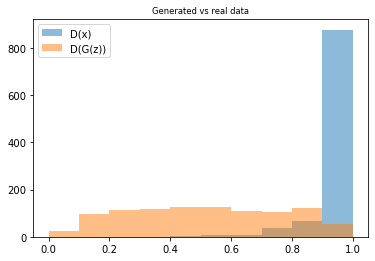

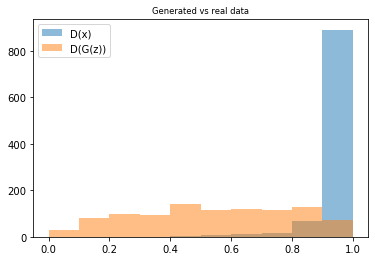

In [20]:
# From this plots we can tell that generator 
# had more potentiall to learn, and could do better.
# Considering the fact that discriminator was a bigger network
# we can assumne that it may have memorized the real data 
sample_probas(1000)
sample_probas(1000)
sample_probas(1000)
sample_probas(1000)

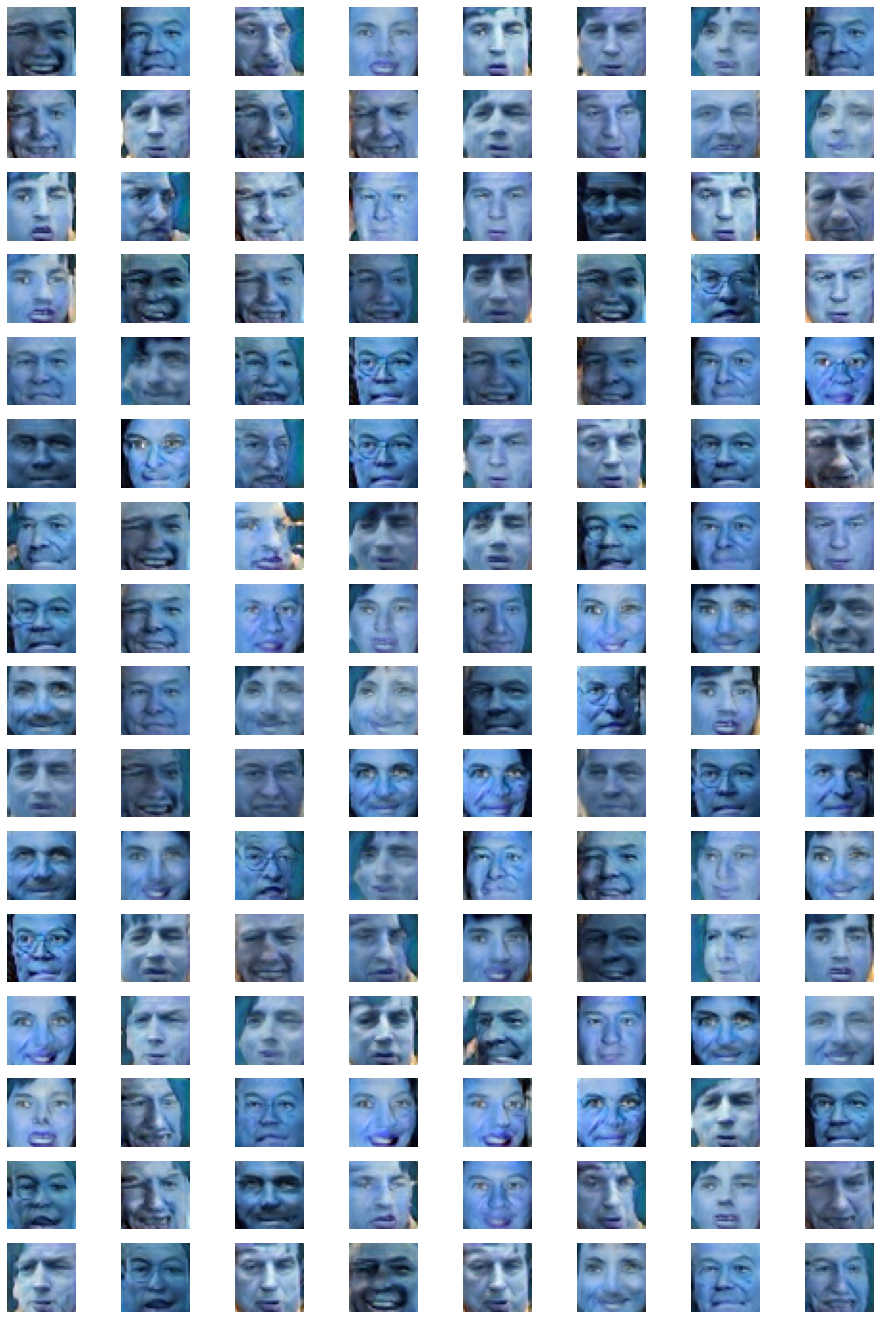

In [10]:
#The network was trained for about 15k iterations. 
#Training for longer yields MUCH better results
plt.figure(figsize=[16,24])
sample_images(16,8)